In [32]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u
from aperturePhot import showimage as show_image

sys.path.append("home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline")
import fpnfix


ModuleNotFoundError: No module named 'fpnfix'

In [2]:
path = "/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline"
day = "20210908"
path_day = os.path.join(path, day)

data_red = Path(path_day, "Reduced Images")
data_red.mkdir(exist_ok = True)

In [3]:
files = ccdp.ImageFileCollection(path_day)
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str20,str11,object,float64,int64,int64
Bias-001.fit,Bias Frame,--,0.0,1024,1024
Bias-002.fit,Bias Frame,--,0.0,1024,1024
Bias-003.fit,Bias Frame,--,0.0,1024,1024
Bias-004.fit,Bias Frame,--,0.0,1024,1024
Bias-005.fit,Bias Frame,--,0.0,1024,1024
Bias-006.fit,Bias Frame,--,0.0,1024,1024
Bias-007.fit,Bias Frame,--,0.0,1024,1024
Bias-008.fit,Bias Frame,--,0.0,1024,1024
Bias-009.fit,Bias Frame,--,0.0,1024,1024


In [4]:
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu")

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [28]:
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks= []
exptime= []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit = 'adu')
    exptime.append(image.header["exposure"])
    reduced_darks.append(ccdp.subtract_bias(image, combined_bias))
    
combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu", scale =1 / np.array(exptime))

combined_darks.header["exposure"] = 1
combined_darks.header['exptime'] = 1

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [30]:
import fpnfix
import ccdproc
import aperturePhot as ap

images = ccdproc.ImageFileCollection(path_day)



combfpn = fpnfix.buildFPNFrame(images) #Note this assumes that the SO Darks were taken as 'Light Frame' 
                                       #with OBJECT='SODark' - use imagetyp and object keyword arguments 
                                       #to change this if needed
                                       
#Show the combined FPN frame build from 60 second SO Darks               
ap.showimage(combfpn[60])
#Show the combined FPN frame build from 10 second SO Darks               
ap.showimage(combfpn[10])

ModuleNotFoundError: No module named 'fpnfix'

In [ ]:
for ccd, file_name in files.ccds(imagetyp='Light Frame',# Just get the bias frames
                                 ccd_kwargs = {'unit': 'adu'},
                                 return_fname=True, # Provide the file name too.
                                  ):
    ccd = ccdp.subtract_bias(ccd, combined_bias)      
    # Subtract the dark current 
    ccd = ccdp.subtract_dark(ccd, combined_darks, exposure_time = 'exptime', exposure_unit = u.second, scale = True)

    # Save the result
    ccd.write(data_red / file_name, overwrite=True)

In [13]:
flat_imagetyp = 'Flat Field'

flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
flat_filters

{'Bessel B', 'Bessel R', 'Bessel V'}

In [20]:
scale = lambda a: 1/np.median(a)

master_flats = {}

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = "adu")
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image, combined_darks, scale=True, exposure_unit=u.s, exposure_time = "exptime")
        reduced_flats.append(image)
    
    combined_flats = ccdp.combine(reduced_flats,
                                 method='median',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, unit = "adu", scale = scale
                                )

    master_flats[filt]=combined_flats.copy()

    combined_flats.write(data_red / (filt.replace("","_")+"_combined_flats.fit"), overwrite = True)

824.5081267356873 1.4826
819.0 832.9126968132039


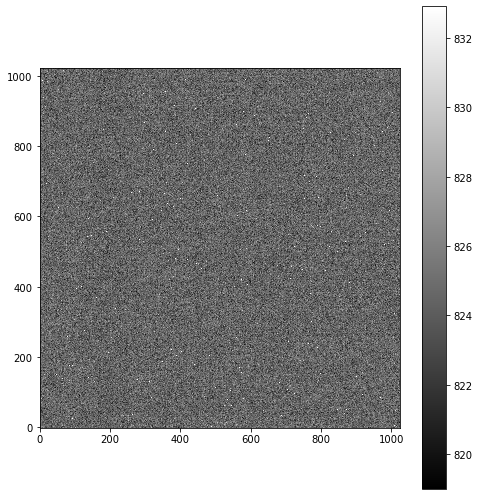

In [21]:
show_image(combined_bias)

0.1698211431503297 0.07412999999999997
-0.1 0.5474334184719558


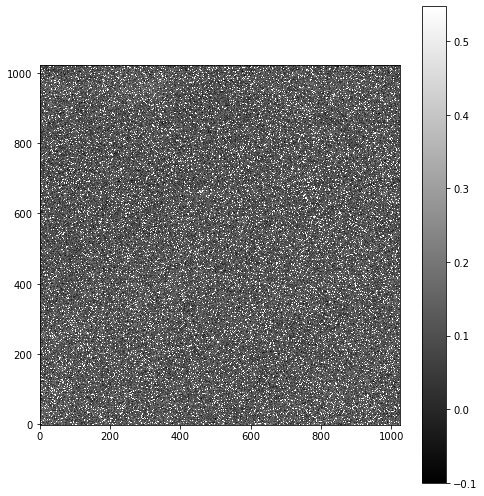

In [22]:
show_image(combined_darks)

1.002242464585387 0.013284580656159574
0.9543039331548073 1.078021899008123


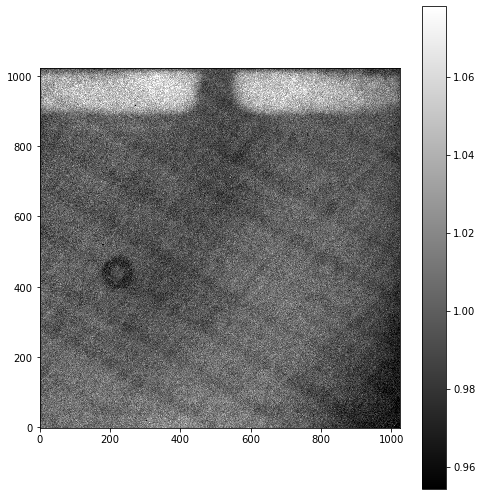

0.9999674088749269 0.006949199284970993
0.9772281639730311 1.0233389954063252


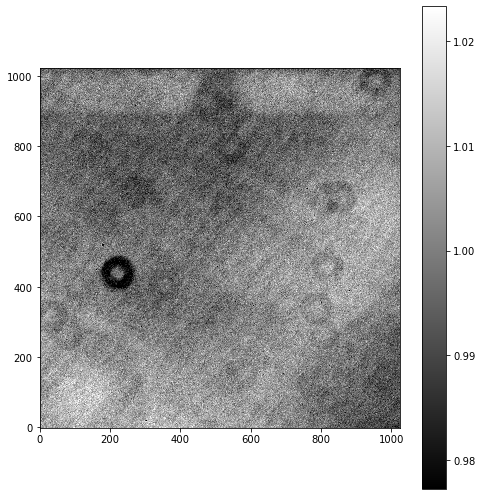

1.0026063105927048 0.009189719792669875
0.9705047380503715 1.0458096140149544


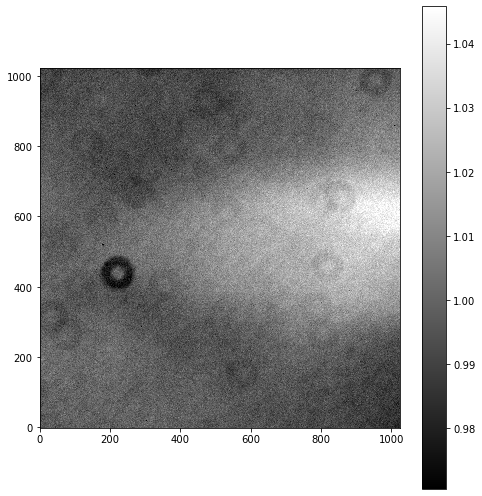

In [23]:
for filt,image in master_flats.items():
    show_image(image)

In [25]:
images = files.files_filtered(imagetype="Light Frame", include_path = True)

for image in images:
    var = ccdp.CCDData.read(image, unit = "adu")
    var_filt = var.header["filter"]
    
    corr_filt = master_flats[var_filt]
    
    var = ccdproc.ccd_process(var,
                             master_bias = combined_bias, dark_frame = combined_darks,
                             master_flat = corr_filt, exposure_key="exposure", exposure_unit = u.second,
                             dark_scale = True)
    proc_data = os.path.basename(image)
    var.write(data_red / ("BDF_"+proc_data), overwrite = True)

In [26]:
data = "Storage/madisonleblanc/persistent/hrpo-pipeline/20210908/TabbysStar2_002V.fit"
f = os.path.join(path, data)

In [27]:
image = ccdp.CCDData.read(f)
show_image(image)

FileNotFoundError: [Errno 2] No such file or directory: '/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/Storage/madisonleblanc/persistent/hrpo-pipeline/20210908/TabbysStar2_002V.fit'